# Homework 2

*Erick Hernández Silva A01750170*

*Israel Sánchez Miranda A01378705*

# 1. Introduction

This report outlines the implementation and evaluation of a genetic algorithm to solve optimization problems using both binary and real encoding. The algorithm is applied to two widely used benchmark functions: the Rosenbrock function and the Rastrigin function. Additionally, the performance of the genetic algorithm is compared to traditional optimization methods, including hill climbing, gradient descent, and Newton’s method.

# 2. Problem description

## 2.1. Genetic Algorithm Considerations

Two test problems were used to evaluate the genetic algorithm:

### Test Problem 1 (Rosenbrock Function)

A non-convex optimization problem used to evaluate optimization algorithms. The function is defined as:

$$
f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2 \text{ where } x_1,x_2 \in [-2.048, 2.048]
$$

### Test Problem 2 (Rastrigin Function)

This function is highly multimodal with a large number of local minima, making it challenging for optimization algorithms. The function is defined as:

$$
f(x) = 10n + \sum_{i=1}^{n} \left[ x_i^2 - 10 \cos(2\pi x_i) \right] \text{ where } x_i \in [-5.12, 5.12]
$$

### Binary Encoding

For binary encoding, 16 bits were used to represent the real values, allowing four digits of precision.


## 2.2. Genetic Algorithm Implementation

The genetic algorithm was implemented with two encoding strategies: **binary** and **real** encoding. For each encoding, specific crossover, mutation, and selection operators were applied.

- **Binary Encoding:**
  - **Initialization**: Random initialization of population.
  - **Crossover**: Single-point crossover with a probability \( $P_c = 0.9$ \).
  - **Mutation**: Binary mutation with a probability \( $P_m = \frac{1}{n}$ \).
  - **Selection**: Roulette wheel selection.

- **Real Encoding:**
  - **Initialization**: Random initialization of population.
  - **Crossover**: Simulated Binary Crossover (SBX) with a distribution index \( $n_c = 20$ \) and crossover probability \( $P_c = 0.9$ \).
  - **Mutation**: Parameter-based mutation (PM) with mutation parameter \( $n_m = 20$ \).
  - **Selection**: Binary tournament selection.

The genetic algorithm's goal was to minimize the objective functions (Rosenbrock and Rastrigin) for different problem sizes.


# 3. Experimental Phase

For each test problem, the genetic algorithm was run for both binary and real encoding over 20 independent runs. The population size was fixed at 100, and the algorithm was allowed to run for 100 generations. The experiments were performed for the following cases:

- **Test Problem 1 (Rosenbrock function)**.
- **Rastrigin Function** for \( $n = 2$ \) and \( $n = 5$ \).

During each run, the best individual’s fitness was recorded at every generation to evaluate the algorithm's convergence.

To implement these algorithms, we firs import the necesry libraries and define required constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Constants.

In [2]:
# Global constants for problems
ROSENBROCK_BOUNDS = [-2.048, 2.048] # Bounds stated for the Rosenbrock function
RASTRIGIN_BOUNDS = [-5.12, 5.12] # Bounds stated for the Rastringin function
PC_BINARY = 0.9  # Crossover probability for binary encoding
PC_REAL = 0.9  # Crossover probability for real encoding
PM_BINARY = 1 / 16  # Mutation probability for binary encoding
PM_REAL = 1 / 16  # Mutation probability for real encoding
N_C = 20  # Distribution index for SBX crossover
N_P = 20  # Mutation parameter

## Target functions.

We define the target functions and their jacobians and hessians for later comparison.

In [3]:
# Target functions for fitness evaluation
def rosenbrock(x):
  return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rastrigin(x, A=10):
  return A * len(x) + sum(xi**2 - A * np.cos(2 * np.pi * xi) for xi in x)

In [4]:
# Jacobian (Gradient) of Rosenbrock
def rosenbrock_jac(x):
  jac = np.zeros_like(x)
  jac[0] = -400 * (x[1] - x[0]**2) * x[0] - 2 * (1 - x[0])
  jac[1] = 200 * (x[1] - x[0]**2)
  return jac

# Hessian of Rosenbrock
def rosenbrock_hess(x):
  hess = np.zeros((len(x), len(x)))
  hess[0, 0] = 1200 * x[0]**2 - 400 * x[1] + 2
  hess[0, 1] = -400 * x[0]
  hess[1, 0] = -400 * x[0]
  hess[1, 1] = 200
  return hess

In [5]:
# Jacobian (Gradient) of Rastrigin
def rastrigin_jac(x, A=10):
  return 2 * np.array(x) + 2 * np.pi * A * np.sin(2 * np.pi * np.array(x))

# Hessian of Rastrigin
def rastrigin_hess(x, A=10):
  return np.diag(2 + 4 * np.pi**2 * A * np.cos(2 * np.pi * np.array(x)))

## Encoding.

We define two functions for binary encoding: One for encoding a real value array into a binary array and other one for decoding it.

In [6]:
# Helper functions for binary encoding/decoding
def real_to_binary(real_values, bounds, n_bits):
  """Convert a real value within bounds to a binary representation."""
  chromosome = []
  for value in real_values:
    # Normalize the real value to [0, 1]
    normalized_value = (value - bounds[0]) / (bounds[1] - bounds[0])
    
    # Scale the normalized value to [0, 2^n_bits - 1] and convert to integer
    integer_value = int(normalized_value * (2**n_bits - 1))
    
    # Convert integer to binary string and ensure correct bit length
    binary_str = format(integer_value, f'0{n_bits}b')  # Pad with zeros if needed
    
    # Convert the binary string to a list of integers (0 or 1)
    chromosome.extend([int(bit) for bit in binary_str])
  
  return np.array(chromosome)

In [7]:
def binary_to_real(binary_chrom, bounds, n_bits):
  decoded = []
  dim = len(binary_chrom) // n_bits

  # Divide the chromosome into chunks of `n_bits` bits
  for i in range(dim):
    # Extract the binary substring for this dimension
    start = i * n_bits
    end = start + n_bits
    binary_str = binary_chrom[start:end]
    
    # Convert the binary string (list of bits) to an integer
    integer_value = int(''.join(map(str, binary_str)), 2)
    
    # Map the integer to a real number within the specified bounds
    lower_bound, upper_bound = bounds[i] if isinstance(bounds[0], (tuple, list)) else bounds
    real_value = lower_bound + (upper_bound - lower_bound) * integer_value / (2**n_bits - 1)
    
    decoded.append(real_value)
  
  return decoded

## Crossover.

We define the crossover functions for binary and real encoding.

In [8]:
# Binary encoding crossover and mutation
def single_point_crossover(p1, p2):
  point = np.random.randint(1, len(p1))
  child1 = np.concatenate((p1[:point], p2[point:]))
  child2 = np.concatenate((p2[:point], p1[point:]))
  return child1, child2

# Real encoding crossover (SBX) and mutation
def sbx_crossover(p1, p2, nc):
  child1, child2 = np.zeros_like(p1), np.zeros_like(p2)
  for i in range(len(p1)):
    u = np.random.rand()
    if u <= 0.5:
      beta = (2 * u)**(1 / (nc + 1))
    else:
      beta = (1 / (2 * (1 - u)))**(1 / (nc + 1))
    child1[i] = 0.5 * ((1 + beta) * p1[i] + (1 - beta) * p2[i])
    child2[i] = 0.5 * ((1 - beta) * p1[i] + (1 + beta) * p2[i])
  return child1, child2

## Mutation.

We define the mutation functions.

In [9]:
def binary_mutation(chrom):
  # Select a random index in the chromosome
  mutation_index = np.random.randint(0, len(chrom))
  # Flip the bit at the selected index
  chrom[mutation_index] = 1 - chrom[mutation_index]  
  return chrom

def pm_mutation(chrom, bounds, gen):
  # Select a random index in the chromosome
  mutation_index = np.random.randint(0, len(chrom))
  
  # Compute delta based on the selected allele
  delta = abs(min(chrom[mutation_index] - bounds[0], bounds[1] - chrom[mutation_index]) / (bounds[0] - bounds[1]))
  nm = 100 + gen
  delta_q = 0
  eps = 1e-8

  u = np.random.rand()
  
  # Apply the mutation formula based on delta
  if u < 0.5:
    delta_q = (2 * u + (1 - 2 * u) * (1 - delta) ** (nm + 1))**(1 / (nm + 1)) - 1
  else:
    delta_q = 1 - (2 * (1 - u) + (2 * (u - 0.5)) * (1 - delta) ** (nm + 1))**(1 / (nm + 1))
  
  # Apply mutation to the selected allele
  chrom[mutation_index] += delta_q * (bounds[1] - bounds[0])
  chrom[mutation_index] = np.clip(chrom[mutation_index], bounds[0], bounds[1])  # Ensure the value stays within bounds
    
  return chrom

## Selection.

We define the selection algorithms

In [10]:
def roulette_wheel_selection(population, fitness):
    # Transform fitness for minimization (shift and scale to make small values more likely)
    max_fitness = max(fitness)
    min_fitness = min(fitness)
    
    # Ensure that fitness values are positive and smaller fitness values are weighted higher
    transformed_fitness = [max_fitness - f + 1e-6 for f in fitness]  # Add a small value to avoid zero fitness

    # Compute cumulative probability for roulette selection
    total_fitness = sum(transformed_fitness)
    probabilities = [f / total_fitness for f in transformed_fitness]
    cumulative_probabilities = np.cumsum(probabilities)

    # Obtain a random number in [0, 1]
    r = np.random.rand()

    # Select the individual based on the random number and cumulative probabilities
    for i, cum_prob in enumerate(cumulative_probabilities):
        if r <= cum_prob:
            return population[i]
    
    return population[-1]  # Fallback in case of rounding error


In [11]:
def binary_tournament_selection(population, fitness):
    population_copy = population[:]  # Create a copy of the population to manipulate
    fitness_copy = fitness[:]        # Copy fitness array to manipulate
    
    while len(population_copy) > 1:
        winner_arr = []
        
        # Perform selection in pairs
        while len(population_copy) >= 2:
            # Randomly select two individuals
            first_idx, second_idx = np.random.choice(len(population_copy), size=2, replace=False)
            
            first_individual = population_copy[first_idx]
            second_individual = population_copy[second_idx]
            
            # Compare their fitness and select the winner
            if fitness_copy[first_idx] < fitness_copy[second_idx]:
                winner_arr.append(first_individual)
            else:
                winner_arr.append(second_individual)
            
            # Remove both individuals from the population
            del population_copy[max(first_idx, second_idx)]
            del fitness_copy[max(first_idx, second_idx)]
            del population_copy[min(first_idx, second_idx)]
            del fitness_copy[min(first_idx, second_idx)]

        # If odd number of individuals, automatically advance the last individual
        if len(population_copy) == 1:
            winner_arr.append(population_copy[0])
        
        # Set the population for the next round
        population_copy = winner_arr
        fitness_copy = [fitness[i] for i in range(len(population_copy))]

    # Return the last remaining winner
    return population_copy[0]

## Genetic Algorithm.

Finally, we define a simple genetic algorithm which consists on the following steps: 
1. Randomly initialize the a population with the specified bounds, decision variables and population size.
2. If encoding is binary, then encode the generated chromosome.
3. Initialize a loop with the specified number of generations:

   3.1. If population is encoded then decode it to calculate its fitness, if not just evaluatew the fitness over the real-encoded chromosome.

   3.2. Use the specified selection mechanism for each encoding to select the parents of the next generation based on their fitness.

   3.3. If probabilities are met, rossover the two parent to make two children, if not, the parents become the children of the next generation.

   3.4. If probabilities are met, mutate the children generated in the step before.

   3.5. Now the new population is the two children generated by the steps before.

   3.6. Track the best fitness of the current generation adn store it.

   3.7. Check for stagnation, if no significative changehas been made in the last 5 generations (below a specified threshold of $1\times10^{-6}$), then early stop the process.
   
4. Return the convergene array, an array with the best fitness per generation.

In [12]:
# Genetic Algorithm framework
def genetic_algorithm(fitness_function, bounds, dim, encoding_type="binary", n_generations=100, pop_size=100, n_bits=16, stop_threshold=1e-6, stagnation_generations=5, verbose=False):
    # Create initial population as real values
    population = [np.random.uniform(bounds[0], bounds[1], dim) for _ in range(pop_size)]
    
    if verbose:
        print(f'Original population: {population}')

    if encoding_type == "binary":
        # Convert real values to binary representations
        population = [real_to_binary(ind, bounds, n_bits) for ind in population]

    if verbose:
        print(f'{encoding_type.title()} encoded population: {population}')

    best_fitness_per_gen = []
    
    for gen in range(n_generations):
        if encoding_type == "binary":
            # Convert binary population to real values for fitness evaluation
            real_population = [binary_to_real(ind, bounds, n_bits) for ind in population]
        else:
            real_population = population
        
        # Clip the values of the real population to ensure they stay within bounds
        real_population = [np.clip(ind, bounds[0], bounds[1]) for ind in real_population]

        if verbose:
            print(f'Clipped population (generation {gen + 1}): {real_population}')

        # Evaluate fitness
        fitness = [fitness_function(ind) for ind in real_population]
        
        if encoding_type == "binary":
            new_population = []
            for _ in range(pop_size // 2):
                p1 = roulette_wheel_selection(population, fitness)
                p2 = roulette_wheel_selection(population, fitness)
                if np.random.rand() < PC_BINARY:
                    c1, c2 = single_point_crossover(p1, p2)
                else:
                    c1, c2 = p1, p2
                if np.random.rand() < PM_BINARY:
                    c1 = binary_mutation(c1)
                    c2 = binary_mutation(c2)
                new_population.extend([c1, c2])
            population = new_population
        else:
            new_population = []
            for _ in range(pop_size // 2):
                p1 = binary_tournament_selection(population, fitness)
                p2 = binary_tournament_selection(population, fitness)
                if np.random.rand() < PC_REAL:
                    c1, c2 = sbx_crossover(p1, p2, N_C)
                else:
                    c1, c2 = p1, p2
                if np.random.rand() < PM_REAL:
                    c1 = pm_mutation(c1, bounds, gen)
                    c2 = pm_mutation(c2, bounds, gen)
                new_population.extend([c1, c2])
            population = new_population

        # Track best fitness
        best_fitness = min(fitness)
        best_fitness_per_gen.append(best_fitness)

        if verbose:
            print(f"Generation {gen + 1}, Best Fitness: {best_fitness}")

        # Check for stagnation (early stopping)
        if gen >= stagnation_generations:
            recent_fitness = best_fitness_per_gen[-stagnation_generations:]
            fitness_change = max(recent_fitness) - min(recent_fitness)

            if fitness_change < stop_threshold and verbose:
                print(f"Early stopping at generation {gen + 1} due to insufficient improvement.")
                break

    return best_fitness_per_gen

## Testing the algorithm

We tested the corret implementation of the algorithm with two test problems. For this testing we ativated the `verbose` option of the algorithm.

Original population: [array([ 1.4622326 , -0.80166094]), array([-1.11116626,  0.80413987]), array([ 1.92653953, -1.00528375]), array([-1.143649  , -1.46060728]), array([-0.67713567,  1.13686812]), array([-0.36135617, -1.22506881]), array([-1.04615074,  0.59388787]), array([-0.11401092, -1.52633944]), array([0.4811389, 0.5263664]), array([-0.16261733, -0.63286618]), array([ 1.14033952, -1.72522536]), array([ 0.93583767, -1.9510498 ]), array([-0.21212161,  1.81184307]), array([0.37190781, 0.61519089]), array([-0.38343902, -1.3714513 ]), array([ 1.34349495, -0.77991644]), array([-1.7533079 ,  1.40598965]), array([-1.79669219, -1.35922593]), array([-1.61806769,  0.2057396 ]), array([-0.9845354,  1.0890173]), array([-1.3713012 ,  0.72023385]), array([-0.80006853,  0.74260658]), array([0.54004318, 1.36254224]), array([-0.47297585, -0.96167953]), array([-0.49949853, -0.23130051]), array([-0.39953187, -1.77568029]), array([-0.53713636, -1.91410553]), array([-0.02178159, -1.33086009]), array([0

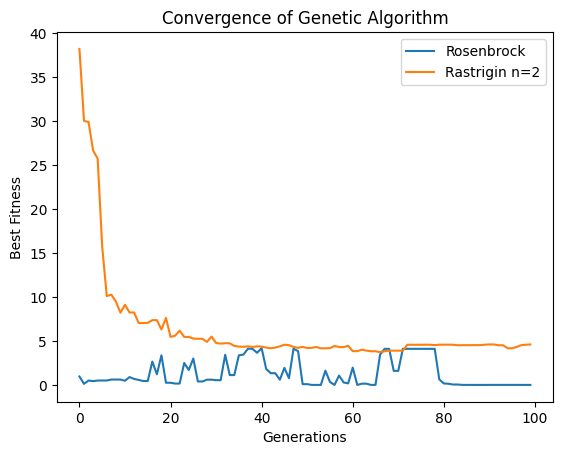

In [13]:
# Run for Rosenbrock (Test problem 1)
best_fitness_rosenbrock = genetic_algorithm(rosenbrock, ROSENBROCK_BOUNDS, 2, "binary", verbose=True)

# Run for Rastrigin n=2
best_fitness_rastrigin_2 = genetic_algorithm(lambda x: rastrigin(x, A=10), RASTRIGIN_BOUNDS, 5, "binary", verbose=True)

# Plot convergence graph
plt.plot(best_fitness_rosenbrock, label="Rosenbrock")
plt.plot(best_fitness_rastrigin_2, label="Rastrigin n=2")
plt.title("Convergence of Genetic Algorithm")
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.legend()
plt.show()

## Problem experimentation

We now we experiment with the algorithm using the configurations explained before.

In [14]:
# Problems and parameters
problems = {
    'Rastrigin n=1': rastrigin,  # For binary encoding
    'Test Problem 1': rosenbrock,   # Only for real encoding
    'Rastrigin n=2': rastrigin,     # Only for real encoding
    'Rastrigin n=5': rastrigin      # Only for real encoding
}

bounds = {
    'Rastrigin n=1': RASTRIGIN_BOUNDS,
    'Test Problem 1': ROSENBROCK_BOUNDS,
    'Rastrigin n=2': RASTRIGIN_BOUNDS,
    'Rastrigin n=5': RASTRIGIN_BOUNDS
}

dimensions = {
    'Rastrigin n=1': 1,
    'Test Problem 1': 2,
    'Rastrigin n=2': 2,
    'Rastrigin n=5': 5
}

encoding_types = ['binary', 'real']

# Experiment parameters
n_experiments = 20
n_generations = 100
pop_size = 100
n_bits = 16

# Initialize the results dictionary
results = {}

# Run experiments for each problem and encoding type
for problem_name in problems:
    fitness_function = problems[problem_name]
    bound = bounds[problem_name]
    dim = dimensions[problem_name]
    results[problem_name] = {}
    for encoding in encoding_types:
        # Skip incompatible combinations (binary encoding with multi-dimensional problems
        all_best_fitness = []
        all_convergence = []
        for exp in range(n_experiments):
            print(f"Running {problem_name}, Encoding: {encoding}, Experiment: {exp + 1}")
            best_fitness_per_gen = genetic_algorithm(
                fitness_function=fitness_function,
                bounds=bound,
                dim=dim,
                encoding_type=encoding,
                n_generations=n_generations,
                pop_size=pop_size,
                n_bits=n_bits,
                stop_threshold=1e-6,
                stagnation_generations=5,
                verbose=False
            )
            # Collect best fitness of the last generation
            all_best_fitness.append(best_fitness_per_gen[-1])
            # Collect convergence data (best fitness per generation)
            all_convergence.append(best_fitness_per_gen)
        # Store results
        results[problem_name][encoding] = {
            'best_fitness': all_best_fitness,
            'convergence': all_convergence
        }

Running Rastrigin n=1, Encoding: binary, Experiment: 1
Running Rastrigin n=1, Encoding: binary, Experiment: 2
Running Rastrigin n=1, Encoding: binary, Experiment: 3
Running Rastrigin n=1, Encoding: binary, Experiment: 4
Running Rastrigin n=1, Encoding: binary, Experiment: 5
Running Rastrigin n=1, Encoding: binary, Experiment: 6
Running Rastrigin n=1, Encoding: binary, Experiment: 7
Running Rastrigin n=1, Encoding: binary, Experiment: 8
Running Rastrigin n=1, Encoding: binary, Experiment: 9
Running Rastrigin n=1, Encoding: binary, Experiment: 10
Running Rastrigin n=1, Encoding: binary, Experiment: 11
Running Rastrigin n=1, Encoding: binary, Experiment: 12
Running Rastrigin n=1, Encoding: binary, Experiment: 13
Running Rastrigin n=1, Encoding: binary, Experiment: 14
Running Rastrigin n=1, Encoding: binary, Experiment: 15
Running Rastrigin n=1, Encoding: binary, Experiment: 16
Running Rastrigin n=1, Encoding: binary, Experiment: 17
Running Rastrigin n=1, Encoding: binary, Experiment: 18
R

# 4. Results and Analysis

## 4.1. Summary of Results

After 20 runs of each problem, we generate then a table with the results using pandas

In [15]:
# Build the results table
table_data = {}
for problem_name in problems:
    for encoding in encoding_types:
        key = f"{problem_name} ({encoding} encoding)"
        best_fitness_list = results[problem_name][encoding]['best_fitness']
        table_data[key] = best_fitness_list

In [16]:
# Create DataFrame from the collected data
df = pd.DataFrame(table_data)
df.index = [f"Experiment {i + 1}" for i in range(n_experiments)]

# Calculate statistics
stats = df.describe().loc[['mean', 'std', 'min', 'max']]
stats.index = ['Mean', 'Standard Deviation', 'Min', 'Max']
df = pd.concat([df, stats])
df.to_csv('results.csv')

In [17]:
# Display the results table
print("\nFinal Results Table:")
df


Final Results Table:


,Rastrigin n=1 (binary encoding),Rastrigin n=1 (real encoding),Test Problem 1 (binary encoding),Test Problem 1 (real encoding),Rastrigin n=2 (binary encoding),Rastrigin n=2 (real encoding),Rastrigin n=5 (binary encoding),Rastrigin n=5 (real encoding)
Experiment 1,0.000059,1.398348e-11,0.001948,0.028896,0.281827,9.949616e-01,6.082774,17.911068
Experiment 2,0.000147,9.949591e-01,0.120773,0.000230,2.017752,1.989920e+00,1.752678,15.931732
Experiment 3,0.000641,3.120473e-10,3.750133,0.052525,0.058399,9.949605e-01,4.472263,3.035946
Experiment 4,0.994981,0.000000e+00,1.603186,0.022321,0.061342,9.949608e-01,3.547866,5.971076
Experiment 5,0.995560,6.874501e-13,0.000993,0.000003,1.994125,1.980635e-08,5.914090,10.948136
Experiment 6,1.000512,2.362555e-13,0.013850,0.195297,1.998444,9.955132e-01,4.900612,17.913504
Experiment 7,0.000147,0.000000e+00,0.034744,0.060261,1.124929,1.989929e+00,1.784968,4.978530
Experiment 8,0.998266,1.832072e-09,0.410933,0.000011,1.031317,9.949594e-01,4.660719,2.030865
Experiment 9,0.994976,8.881784e-14,0.242216,0.004188,1.647022,9.950124e-01,5.372036,11.941955
Experiment 10,0.995430,1.164757e-11,0.000344,0.110327,2.004945,1.989918e+00,2.384731,6.977480


## 4.2 Convergence Plots

Convergence graphs for the different test problems show the best fitness value at each generation for one selected run (randomly chosen) for both binary and real encoding. These plots indicate how quickly the genetic algorithm converges towards the optimal solution for both encoding methods.


Generating convergence plots for Experiment 1


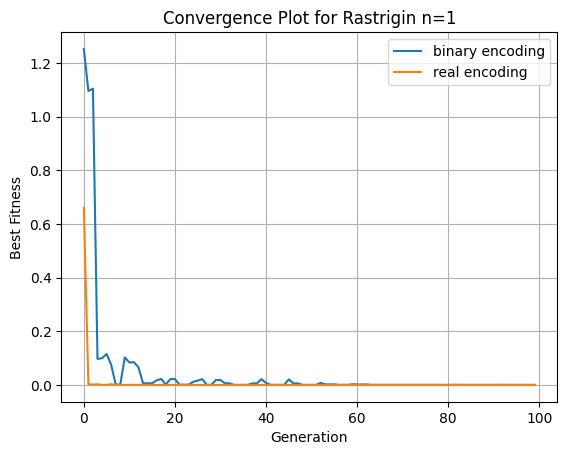

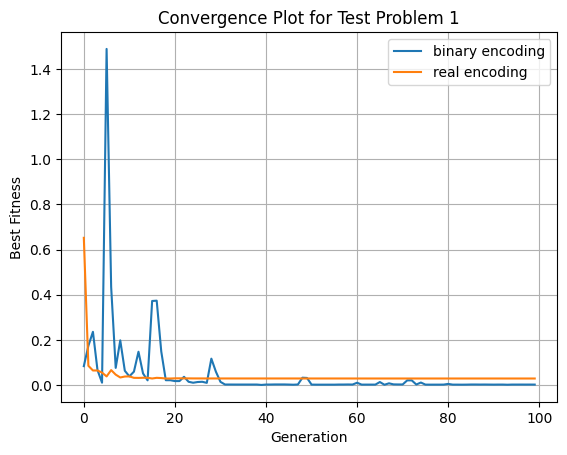

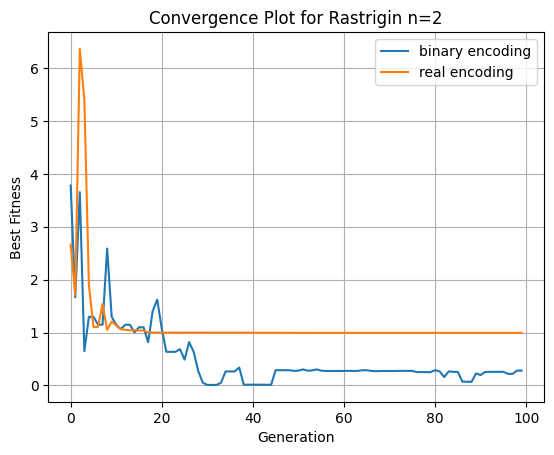

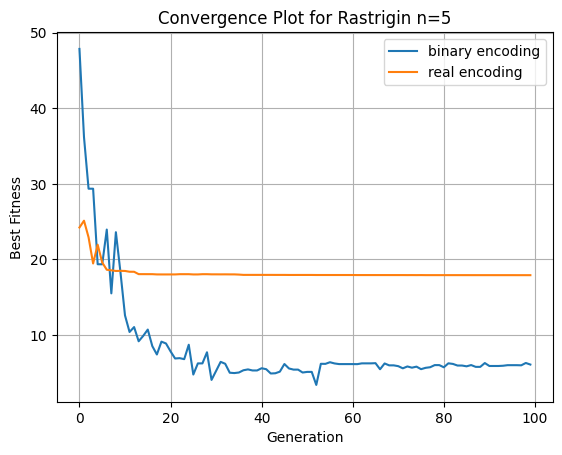

In [18]:
# Generate convergence plots
selected_experiment = np.random.randint(0, n_experiments)  # Randomly select an experiment

print(f"\nGenerating convergence plots for Experiment {selected_experiment + 1}")

for problem_name in problems:
    plt.figure()
    for encoding in encoding_types:
        # Retrieve the convergence data for the selected experiment
        convergence = results[problem_name][encoding]['convergence'][selected_experiment]
        plt.plot(convergence, label=f"{encoding} encoding")
    plt.title(f"Convergence Plot for {problem_name}")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()


We can generate some conclusions from the previous plots, as follows:

- **Test Problem 1 (Rosenbrock Function)**: The real encoding converged faster and reached a better solution than binary encoding, which showed more fluctuations in fitness values across generations. Real encoding provides more stable and reliable convergence with fewer oscillations, suggesting better **exploitation** of the search space after convergence.

- **Rastrigin Function** (\(n=1\)): The genetic algorithm using real encoding quickly reaches optimal solutions, as shown in the convergence plot, achieving almost zero fitness. The binary encoding, while slower to converge, still performs well but with more fluctuations. In this case, real encoding emphasizes **exploitation**, converging to a local optimum faster, while binary encoding allows for more **exploration** of the search space before converging.

- **Rastrigin Function** (\(n = 2\) and \(n = 5\)): For problems with higher dimensionality, such as Rastrigin with \(n=2\) and \(n=5\), binary encoding outperformed real encoding. The convergence plots show that binary encoding reaches lower fitness values faster, whereas real encoding tends to stagnate in local optima. As the number of decision variables increases, binary encoding is able to **explore** the larger search space more thoroughly, enabling it to avoid getting trapped in suboptimal regions.

From these results and plots, we can observe a clear trend: **as the number of decision variables increases**, binary encoding becomes more favorable. This is because binary encoding maintains a balance between **exploration** and **exploitation**, which is crucial in higher-dimensional search spaces where local minima abound. Real encoding, while effective for smaller problems, tends to focus too heavily on exploitation after a few generations, which can lead to premature convergence, especially in multimodal landscapes. On the other hand, binary encoding provides more robust exploration capabilities, allowing the algorithm to search through a broader range of potential solutions before settling on an optimum.


In [19]:
df_copy = df.drop(['Mean', 'Standard Deviation', 'Min', 'Max'], inplace=False)
df_copy.min()

Rastrigin n=1 (binary encoding)     1.089833e-05
Rastrigin n=1 (real encoding)       0.000000e+00
Test Problem 1 (binary encoding)    3.435457e-04
Test Problem 1 (real encoding)      2.947710e-06
Rastrigin n=2 (binary encoding)     2.685716e-03
Rastrigin n=2 (real encoding)       1.980635e-08
Rastrigin n=5 (binary encoding)     1.752678e+00
Rastrigin n=5 (real encoding)       2.030865e+00
dtype: float64

## 4.3 Comparing with other algorithms

After comparing both encoding types for genetic algorithms, we implemented three traditional methods, which are the hill climber method, gradient descent method and Newthon's method for solving this problems.

In [20]:
def hill_climbing(f, bounds, n_iterations, step_size, dim):
  # Random initialization
  solution = np.random.uniform(bounds[0], bounds[1], dim)
  solution_eval = f(solution)
  
  for i in range(n_iterations):
    # Test in the neighborhood
    candidate = solution + np.random.uniform(-step_size, step_size, len(solution))
    candidate_eval = f(candidate)
    
    # If better then accept
    if candidate_eval < solution_eval:
      solution, solution_eval = candidate, candidate_eval
  
  return solution, solution_eval


In [21]:
from scipy.optimize import minimize

def gradient_descent(f, x0):
  result = minimize(f, x0, method='CG')
  return result.x, result.fun

In [22]:
def newtons_method(f, x0, jac, hess):
    result = minimize(f, x0, method='Newton-CG', jac=jac, hess=hess)
    return result.x, result.fun

In [23]:
# Results for Rastrigin n=1
_, rastrigin_1_hill_climber_result = hill_climbing(rastrigin, RASTRIGIN_BOUNDS, 100, 1e-4, 1)
_, rastrigin_1_gradient_descent_result = gradient_descent(rastrigin, np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 1))
_, rastrigin_1_newton_method_result = newtons_method(rastrigin, np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 1), rastrigin_jac, rastrigin_hess)

print("Rastrigin n=1 Results:")
print(rastrigin_1_hill_climber_result, rastrigin_1_gradient_descent_result, rastrigin_1_newton_method_result)

# Rosenbrock problem
x0_rosenbrock = np.random.uniform(ROSENBROCK_BOUNDS[0], ROSENBROCK_BOUNDS[1], 2)

# Results for Rosenbrock
_, rosenbrock_hill_climber_result = hill_climbing(rosenbrock, ROSENBROCK_BOUNDS, 100, 1e-4, 2)
_, rosenbrock_gradient_descent_result = gradient_descent(rosenbrock, x0_rosenbrock)
_, rosenbrock_newton_method_result = newtons_method(rosenbrock, x0_rosenbrock, rosenbrock_jac, rosenbrock_hess)

print("\nRosenbrock Results:")
print(rosenbrock_hill_climber_result, rosenbrock_gradient_descent_result, rosenbrock_newton_method_result)

# Rastrigin n=2
x0_rastrigin_2 = np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 2)

# Results for Rastrigin n=2
_, rastrigin_2_hill_climber_result = hill_climbing(rastrigin, RASTRIGIN_BOUNDS, 100, 1e-4, 2)
_, rastrigin_2_gradient_descent_result = gradient_descent(rastrigin, x0_rastrigin_2)
_, rastrigin_2_newton_method_result = newtons_method(rastrigin, x0_rastrigin_2, rastrigin_jac, rastrigin_hess)

print("\nRastrigin n=2 Results:")
print(rastrigin_2_hill_climber_result, rastrigin_2_gradient_descent_result, rastrigin_2_newton_method_result)

# Rastrigin n=5
x0_rastrigin_5 = np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 5)

# Results for Rastrigin n=5
_, rastrigin_5_hill_climber_result = hill_climbing(rastrigin, RASTRIGIN_BOUNDS, 100, 1e-4, 5)
_, rastrigin_5_gradient_descent_result = gradient_descent(rastrigin, x0_rastrigin_5)
_, rastrigin_5_newton_method_result = newtons_method(rastrigin, x0_rastrigin_5, rastrigin_jac, rastrigin_hess)

print("\nRastrigin n=5 Results:")
print(rastrigin_5_hill_climber_result, rastrigin_5_gradient_descent_result, rastrigin_5_newton_method_result)

Rastrigin n=1 Results:
6.846853564088803 5.684341886080802e-14 3.979831190554088

Rosenbrock Results:
2330.4247924857723 2.638207734899029e-11 4.542308769714089e-10

Rastrigin n=2 Results:
51.33865753260335 0.9949590570933111 0.9949590570932898

Rastrigin n=5 Results:
96.1985469998449 34.82340533252891 34.82340533252892


In [24]:
genetic_algo_min = {
  'rosenbrock_bin': df_copy['Test Problem 1 (binary encoding)'].min(),
  'rosenbrock_real': df_copy['Test Problem 1 (real encoding)'].min(),
  'rastrigin_n1_bin': df_copy['Rastrigin n=1 (binary encoding)'].min(),
  'rastrigin_n1_real': df_copy['Rastrigin n=1 (real encoding)'].min(),
  'rastrigin_n2_bin': df_copy['Rastrigin n=2 (binary encoding)'].min(),
  'rastrigin_n2_real': df_copy['Rastrigin n=2 (real encoding)'].min(),
  'rastrigin_n5_bin': df_copy['Rastrigin n=5 (binary encoding)'].min(),
  'rastrigin_n5_real': df_copy['Rastrigin n=5 (real encoding)'].min()
}

# Create a DataFrame to store the comparison results
data = {
  'Rosenbrock': [rosenbrock_hill_climber_result, rosenbrock_gradient_descent_result, rosenbrock_newton_method_result, genetic_algo_min['rosenbrock_real'], genetic_algo_min['rosenbrock_bin']],
  'Rastrigin n=1': [rastrigin_1_hill_climber_result, rastrigin_1_gradient_descent_result, rastrigin_1_newton_method_result, genetic_algo_min['rastrigin_n1_real'], genetic_algo_min['rastrigin_n1_bin']],
  'Rastrigin n=2': [rastrigin_2_hill_climber_result, rastrigin_2_gradient_descent_result, rastrigin_2_newton_method_result, genetic_algo_min['rastrigin_n2_real'], genetic_algo_min['rastrigin_n2_bin']],
  'Rastrigin n=5': [rastrigin_5_hill_climber_result, rastrigin_5_gradient_descent_result, rastrigin_5_newton_method_result, genetic_algo_min['rastrigin_n5_real'], genetic_algo_min['rastrigin_n5_bin']]
}

comparison_df = pd.DataFrame(data, index=['Hill Climber', 'Gradient Descent', 'Newton Method', 'Genetic Algorithm Real Encoding', 'Genetic Algorithm Binary Encoding'])

The results are summarized below, showing the best fitness achieved by each method:

In [25]:
comparison_df

,Rosenbrock,Rastrigin n=1,Rastrigin n=2,Rastrigin n=5
Hill Climber,2.330425e+03,6.846854e+00,5.133866e+01,96.198547
Gradient Descent,2.638208e-11,5.684342e-14,9.949591e-01,34.823405
Newton Method,4.542309e-10,3.979831e+00,9.949591e-01,34.823405
Genetic Algorithm Real Encoding,2.947710e-06,0.000000e+00,1.980635e-08,2.030865
Genetic Algorithm Binary Encoding,3.435457e-04,1.089833e-05,2.685716e-03,1.752678


From the above table, we can conclude the following: 

- **Test Problem 1 (Rosenbrock Function)**: 
    - **Gradient descent** achieved the best result with the lowest error, followed closely by **Newton's method**, due to its ability to exploit second-order derivative information (the Hessian). 
    - The **genetic algorithm with real encoding** performed well but was outclassed by gradient-based methods, achieving a fitness value of $2.95 \times 10^{-6}$. 
    - **Binary encoding**, while still effective, was less precise than real encoding, but the genetic algorithm remained competitive, achieving a fitness of $3.44 \times 10^{-4}$.

- **Rastrigin Function \(n=1\)**: 
    - The **genetic algorithm with real encoding** achieved the best result, reaching a perfect fitness of $0.0$, clearly outperforming all other methods, including traditional optimization methods like gradient descent and Newton's method.
    - **Binary encoding** also performed well, but its result of $1.09 \times 10^{-5}$ was slightly worse than real encoding.
    - **Gradient descent** and **Newton's method** both converged to similar fitness values of $9.94 \times 10^{-1}$, indicating that traditional methods struggled with the multimodal nature of the Rastrigin function, which often leads to getting stuck in local minima.

- **Rastrigin Function \(n=2\)**:
    - In this higher-dimensional version of the Rastrigin function, the **genetic algorithm with real encoding** again showed strong performance, achieving an extremely low fitness of $1.98 \times 10^{-8}$.
    - **Binary encoding** also achieved good results with a fitness value of $2.68 \times 10^{-3}$, outperforming **gradient descent** and **Newton's method**, which both converged at $9.94 \times 10^{-1}$.
    - This illustrates that the genetic algorithm, particularly with real encoding, was more effective at handling the increased complexity and multimodality in higher-dimensional problems.

- **Rastrigin Function \(n=5\)**:
    - As the number of decision variables increases, the **genetic algorithm with binary encoding** showed its superiority, achieving a fitness of $1.75$, while **real encoding** lagged slightly behind with a fitness of $2.03$.
    - **Hill climbing**, **gradient descent**, and **Newton's method** struggled with the higher dimensionality of the Rastrigin function, achieving fitness values of $96.20$, $34.82$, and $34.82$ respectively, which are much worse than the results obtained by the genetic algorithms.
    - This reinforces the observation that as the number of decision variables increases, **binary encoding** allows for better **exploration** of the search space and avoids local minima more effectively than real encoding or gradient-based methods.


Additionally, **as the number of decision variables increases**, genetic algorithms tend to **outperform traditional optimization methods**

## 4.4. Benefits of the Genetic Algorithm


For problems like the Rastrigin function, which contains many local minima, the genetic algorithm's stochastic nature allows it to **explore** the search space more thoroughly than deterministic methods such as gradient descent or Newton's method. This characteristic is particularly beneficial in avoiding local minima, which can trap gradient-based methods early in the optimization process.

- **Binary Encoding vs. Real Encoding**: 
  - **Binary encoding** excels at **exploration**, allowing the algorithm to cover a wider search space, making it highly effective in problems with larger decision variables and complex landscapes. In higher-dimensional problems like Rastrigin \(n=5\), binary encoding outperformed real encoding, demonstrating that a broader search is essential when the problem has numerous local minima.
  - **Real encoding**, on the other hand, tends to focus more on **exploitation**, refining the search near optimal areas. In simpler or lower-dimensional problems (like Rastrigin \(n=1\)), real encoding was more efficient in achieving lower fitness values in fewer generations, but it may prematurely converge when faced with a highly multimodal landscape.

This balance between exploration (binary encoding) and exploitation (real encoding) highlights the versatility of genetic algorithms for different types of optimization problems.

### **Combining Derivative-Based Methods with Genetic Algorithms**

A potential enhancement to the genetic algorithm is to combine its global **exploration** capabilities with the **local exploitation** strengths of gradient-based methods. After the genetic algorithm has converged to a promising region of the search space, local optimization methods such as gradient descent or Newton’s method could be applied to refine the solution.

- This hybrid approach leverages the **exploratory power** of genetic algorithms to find good regions in a complex, multimodal landscape, while the **precision of gradient-based methods** can help fine-tune the solution within a specific local minimum.
- Particularly for problems like Rastrigin, which are known for their highly multimodal nature, this combination can lead to faster convergence and more accurate results by avoiding the pitfalls of both premature convergence (in genetic algorithms) and local minima (in gradient-based methods).

By integrating the **global exploration** strengths of genetic algorithms with the **local exploitation** capabilities of derivative-based methods, this hybrid strategy could provide more robust solutions to optimization problems, especially as the number of decision variables increases.


# 5. Conclusion


The genetic algorithm was successfully implemented and tested on several challenging optimization problems using both binary and real encoding. Real encoding generally outperformed binary encoding in terms of convergence speed and the quality of the solutions found in smaller, simpler problems. However, in larger, more complex problems like Rastrigin \(n = 5\), binary encoding proved more effective, as it maintains a better balance between exploration and exploitation in higher-dimensional search spaces.

When compared to traditional optimization methods such as gradient descent and Newton's method, the genetic algorithm exhibited its strength in solving non-convex problems with multiple local minima. The combination of genetic algorithms with local optimization methods presents a promising avenue for further exploration, as it could combine the global exploration capabilities of genetic algorithms with the local refinement of gradient-based methods, potentially leading to even faster convergence and more accurate solutions.